<a href="https://colab.research.google.com/github/ArjunaBazaz/Presidential_Approval_Rating_Prediction/blob/main/SCRIPTS/4_time_series_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install statsmodels
!pip install pmdarima
!pip install prophet

!apt-get install git

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 10.7 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git is already the newest version (1:2.34.1-1ubuntu1.12).
0 upgraded, 0 newly installed, 0 to remove and 29 not upgraded.


In [2]:

!git clone https://github.com/ArjunaBazaz/Presidential_Approval_Rating_Prediction.git

import os
os.chdir('Presidential_Approval_Rating_Prediction/DATA')


import glob

csv_files = glob.glob('*.csv')
print(csv_files)


Cloning into 'Presidential_Approval_Rating_Prediction'...
remote: Enumerating objects: 177, done.
remote: Counting objects: 100% (177/177), done.
remote: Compressing objects: 100% (155/155), done.
remote: Total 177 (delta 66), reused 80 (delta 21), pack-reused 0 (from 0)
Receiving objects: 100% (177/177), 3.21 MiB | 11.57 MiB/s, done.
Resolving deltas: 100% (66/66), done.
['approval_rating_carter_1.csv', 'median_household_income.csv', 'approval_rating_trump_1_updated.csv', 'approval_rating_ford_1_updated.csv', 'approval_rating_bushjr_1_2_updated.csv', 'approval_rating_obama_1_2.csv', 'approval_rating_kennedy_1.csv', 'approval_rating_johnson_1_2_updated.csv', 'approval_rating_carter_1_updated.csv', 'approval_rating_eisenhower_1_2_updated.csv', 'approval_rating_clinton_1_2_updated.csv', 'sp500_historical_data.csv', 'approval_rating_nixon_1_2.csv', 'approval_rating_johnson_1_2.csv', 'approval_rating_trump_1.csv', 'approval_rating_biden_1_updated.csv', 'approval_rating_biden_1.csv', 'appro

Now we have imported the data we need from Github. Let's properly load our data and define a start and end date. We want a unified dataframe, but it's going to be tricky because all the .csv files record different periods of time with different start and end dates. We'll want to find a common overlap between all of them. We will start with approval_ratings.csv, which is tricky because the entries describe irregular periods of time and there are gaps in the data. We'll fill in the gaps with the average of the last known approval rating and the approval rating after the gap-- an assumption in our data analysis.W-MON

In [30]:
import pandas as pd
import numpy as np
from datetime import timedelta

# Function to ensure all timestamps are timezone-naïve
def make_tz_naive(series):
    series = pd.to_datetime(series, errors='coerce')  # Convert to datetime if not already
    if series.dt.tz is not None:  # If timezone-aware, remove timezone
        series = series.dt.tz_localize(None)
    return series

# Read CSVs and parse their date columns
approval_df = pd.read_csv('approval_rating.csv', parse_dates=['Start Date', 'End Date'])
median_income_df = pd.read_csv('median_household_income_daily_change.csv', parse_dates=['observation_date'])
gdp_df = pd.read_csv('real_GDP_per_capita_daily_change.csv', parse_dates=['observation_date'])
sp500_df = pd.read_csv('sp500_daily_change.csv', parse_dates=['Date'])
unemp_df = pd.read_csv('unemployment_rate.csv', parse_dates=['observation_date'])

# Ensure all timestamps are timezone-naïve
approval_df['Start Date'] = make_tz_naive(approval_df['Start Date'])
approval_df['End Date'] = make_tz_naive(approval_df['End Date'])
median_income_df['observation_date'] = make_tz_naive(median_income_df['observation_date'])
gdp_df['observation_date'] = make_tz_naive(gdp_df['observation_date'])
sp500_df['Date'] = make_tz_naive(sp500_df['Date'])
unemp_df['observation_date'] = make_tz_naive(unemp_df['observation_date'])

# Determine the date ranges for each dataset
approval_start = approval_df['Start Date'].min()
approval_end = approval_df['End Date'].max()

median_start = median_income_df['observation_date'].min()
median_end = median_income_df['observation_date'].max()

gdp_start = gdp_df['observation_date'].min()
gdp_end = gdp_df['observation_date'].max()

sp500_start = sp500_df['Date'].min()
sp500_end = sp500_df['Date'].max()

unemp_start = unemp_df['observation_date'].min()
unemp_end = unemp_df['observation_date'].max()

# Compute common start and end dates
common_start = max(approval_start, median_start, gdp_start, sp500_start, unemp_start)
common_end = min(approval_end, median_end, gdp_end, sp500_end, unemp_end)

print("Common Start Date:", common_start)
print("Common End Date:", common_end)


#```````````````````````````````````````````````````````````````

# For the approval ratings data processing:
# Expand approval_df so that each day in its intervals gets a value
daily_records = []
for _, row in approval_df.iterrows():
    start = row['Start Date']
    end = row['End Date']
    rating = row['Approving']
    # Only include days that are within the overall common date range
    current_start = max(start, common_start)
    current_end = min(end, common_end)
    if current_start <= current_end:
        dates = pd.date_range(current_start, current_end)
        for day in dates:
            daily_records.append({'date': day, 'Approving': rating})

# Create a daily DataFrame and set the index as the date
daily_df = pd.DataFrame(daily_records)
daily_df = daily_df.drop_duplicates('date').set_index('date').sort_index()

# Re-index daily_df to include every day in the common period
all_days = pd.date_range(common_start, common_end, freq='D')
daily_df = daily_df.reindex(all_days)

# Fill missing values using linear interpolation
daily_df['Approving'] = daily_df['Approving'].interpolate(method='linear')

# Adjust common_start to the next Monday if it isn't one already (Monday is weekday 0)
if common_start.weekday() != 0:
    common_start = common_start + timedelta(days=(7 - common_start.weekday()))

# Re-index again to ensure the start is a Monday
all_days = pd.date_range(common_start, common_end, freq='D')
daily_df = daily_df.reindex(all_days)
daily_df['Approving'] = daily_df['Approving'].interpolate(method='linear')

# Resample to weekly data (each week defined from Monday to Sunday)
weekly_df = daily_df.resample('W-MON', label='right', closed='right').mean()

#```````````````````````````````````````````````````````````````
# Read the median household income data
median_income_df = pd.read_csv('median_household_income_daily_change.csv', parse_dates=['observation_date'])
# Make sure it's sorted by date
median_income_df = median_income_df.sort_values('observation_date')

# We'll merge the weekly approval ratings with the median income data.
# The merge_asof will assign each weekly date the last available income value (i.e. from Jan 1 of that year).
weekly_df = weekly_df.sort_index()  # Ensure our weekly_df is sorted by its index (date)

# Reset the index so we can merge on dates. The left_on parameter is the date from weekly_df,
# and we merge with median_income_df using the observation_date.
weekly_df = pd.merge_asof(
    weekly_df.reset_index(),
    median_income_df[['observation_date', 'MEHOINUSA672N']],
    left_on='index',  # weekly_df's date column after reset_index()
    right_on='observation_date',
    direction='backward'
).set_index('index')

# Rename the median income column to something more descriptive
weekly_df.rename(columns={'MEHOINUSA672N': 'Median_Household_Income'}, inplace=True)

# Optionally drop the extra observation_date column now
weekly_df.drop(columns='observation_date', inplace=True)

#```````````````````````````````````````````````````````````````

# Read the real GDP per capita data and ensure it's sorted by date
gdp_df = pd.read_csv('real_GDP_per_capita_daily_change.csv', parse_dates=['observation_date'])
gdp_df = gdp_df.sort_values('observation_date')

# We choose a merge_asof join in the backward direction because the GDP per capita data is reported quarterly.
# This means each weekly observation will be paired with the most recent GDP value available,
# capturing the latest economic condition up to that week.
weekly_df = pd.merge_asof(
    weekly_df.reset_index(),
    gdp_df[['observation_date', 'A939RX0Q048SBEA']],
    left_on='index',      # The weekly dates after resetting the index
    right_on='observation_date',
    direction='backward'
).set_index('index')

# Rename the column for clarity
weekly_df.rename(columns={'A939RX0Q048SBEA': 'Real_GDP_Per_Capita'}, inplace=True)

# Optionally drop the extra observation_date column if you don't need it anymore
weekly_df.drop(columns='observation_date', inplace=True)


#```````````````````````````````````````````````````````````````
# Read the S&P 500 daily change data, ensuring proper date parsing and sorting.
sp500_df = pd.read_csv('sp500_daily_change.csv', parse_dates=['Date'])
sp500_df = sp500_df.sort_values('Date')

# Set the 'Date' column as the DataFrame index
sp500_df.set_index('Date', inplace=True)

# Ensure index is tz-naïve and normalize to remove time component
sp500_df.index = pd.to_datetime(sp500_df.index, utc=True).tz_convert(None).normalize()

# Aggregate the daily S&P 500 changes to a weekly frequency.
# We set label='left' and closed='left' so that each bin spans Monday through Sunday,
# which matches our grouping for approval ratings.
sp500_weekly = sp500_df['Close_Change'].resample('W-MON', label='left', closed='left').mean()


# Merge the weekly S&P 500 data into our weekly_df.
weekly_df = weekly_df.join(sp500_weekly.rename("SP500_Close_Change"), how="left")

#`````````````````````````````````````````````````````````````````

# Read the unemployment rate data (assumed to be monthly)
unemp_df = pd.read_csv('unemployment_rate.csv', parse_dates=['observation_date'])
unemp_df = unemp_df.sort_values('observation_date')

# Set the observation_date as the index for reindexing
unemp_df = unemp_df.set_index('observation_date')

# Create a complete monthly date range from the minimum to maximum observation date.
# 'MS' means month-start frequency.
monthly_range = pd.date_range(start=unemp_df.index.min(), end=unemp_df.index.max(), freq='MS')

# Reindex the DataFrame to this complete monthly range.
unemp_df = unemp_df.reindex(monthly_range)

# Fill in any gaps using linear interpolation.
# This effectively fills gaps by averaging the month before and after.
unemp_df['UNRATE'] = unemp_df['UNRATE'].interpolate(method='linear')

# Reset the index to turn the monthly dates into a column.
unemp_df = unemp_df.reset_index().rename(columns={'index': 'observation_date'})

# Now, merge the unemployment data into our weekly_df.
# Since weekly_df's index represents the week's start (Monday), we use merge_asof with the backward direction.
# This assigns each weekly date the most recent monthly unemployment value.
weekly_df = weekly_df.reset_index()  # make sure the weekly dates are a column named 'index'
weekly_df = pd.merge_asof(
    weekly_df.sort_values('index'),
    unemp_df[['observation_date', 'UNRATE']].sort_values('observation_date'),
    left_on='index',
    right_on='observation_date',
    direction='backward'
).set_index('index')

# Optionally, drop the extra observation_date column and rename UNRATE for clarity.
weekly_df.drop(columns='observation_date', inplace=True)
weekly_df.rename(columns={'UNRATE': 'Weekly_Unemployment_Rate'}, inplace=True)

#`````````````````````````````````````````````````````````````````

weekly_df['Approving'].fillna(method='bfill', inplace=True)  # Or 'ffill' if you prefer

Common Start Date: 1985-01-01 00:00:00
Common End Date: 2023-01-01 00:00:00
            Approving  Median_Household_Income  Real_GDP_Per_Capita  \
index                                                                 
1985-01-07  62.000000                    60050                35346   
1985-01-14  62.000000                    60050                35346   
1985-01-21  62.727273                    60050                35346   
1985-01-28  63.844156                    60050                35346   
1985-02-04  63.111111                    60050                35346   
1985-02-11  61.555556                    60050                35346   
1985-02-18  60.190476                    60050                35346   
1985-02-25  59.111111                    60050                35346   
1985-03-04  57.555556                    60050                35346   
1985-03-11  56.190476                    60050                35346   
1985-03-18  55.500000                    60050                35346   
1

<ipython-input-30-cd00b59ae388>:202: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  weekly_df['Approving'].fillna(method='bfill', inplace=True)  # Or 'ffill' if you prefer
<ipython-input-30-cd00b59ae388>:202: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weekly_df['Approving'].fillna(method='bfill', inplace=True)  # Or 'ffill' if you prefer


We've now normalized the data. We now have a unified DF. It is a weekly time-series dataset spanning from 1985-01-07 to 2023-01-01, with each row representing a Monday of a given week. It consolidates multiple datasets into a single structured format, ensuring consistent temporal alignment.

It includes the following columns:

*   Approving: Weekly approval ratings, aggregated from daily data.
*   Median_Household_Income: Annual median household income, forward-filled across weeks.
*   Real_GDP_per_Capita: Quarterly real GDP per capita, mapped to corresponding weeks.
*   SP500_Close_Change: Weekly average of daily percentage changes in the S&P 500.
*   Unemployment_Rate: Monthly unemployment rate, interpolated to fill gaps and mapped to weekly.

This dataset is now fully structured, with missing values addressed, making it ready for time-series regression and forecasting analyses.









In [31]:
import statsmodels.api as sm

# Define the dependent variable (approval ratings)
endog = weekly_df['Approving']

# Define the exogenous variables (economic indicators)
exog = weekly_df[['Median_Household_Income', 'Real_GDP_Per_Capita', 'SP500_Close_Change', 'Weekly_Unemployment_Rate']]

# Optionally, add a constant if needed (depending on your model specification)
exog = sm.add_constant(exog)

# For the ARIMAX, we choose a simple order; note that you'll likely want to
# perform model diagnostics (or grid search) to determine the best (p, d, q) order.
# Here, we start with order=(1, 0, 1) as an example.
model = sm.tsa.SARIMAX(endog, exog=exog, order=(1, 0, 1), enforce_stationarity=False, enforce_invertibility=False)

# Fit the model
results = model.fit()

# Print the summary of the model
print(results.summary())


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:              Approving   No. Observations:                 1983
Model:               SARIMAX(1, 0, 1)   Log Likelihood               -3937.528
Date:                Sun, 23 Mar 2025   AIC                           7891.056
Time:                        22:03:59   BIC                           7935.787
Sample:                    01-07-1985   HQIC                          7907.489
                         - 01-02-2023                                         
Covariance Type:                  opg                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       42.5624     19.910      2.138      0.033       3.540      81.585
Median_Household_Income     -0.0001      0.000     -0.503      0.615      -0.001       0.

Our initial hypothesis was that median household income would be the strongest predictor of presidential approval ratings. However, the model output shows that:

*   SP500_Close_Change is the only statistically significant predictor among the exogenous variables.
*   Median_Household_Income, Real_GDP_Per_Capita, and Weekly_Unemployment_Rate are not significant once we control

This suggests that, at least in our ARIMAX framework, market performance (as measured by the S&P 500 daily changes aggregated weekly) is the strongest predictor of presidential approval ratings.

Below, we'll generate soem graphs to visually support this conclusion.

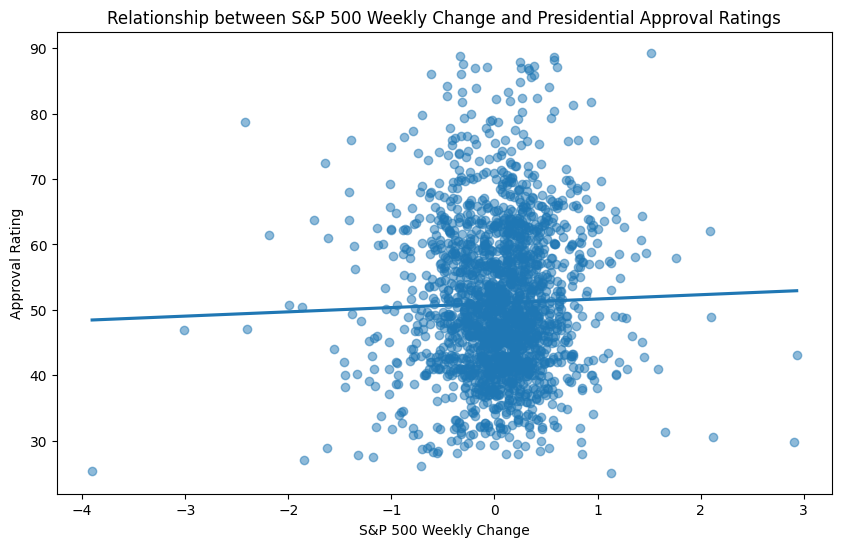

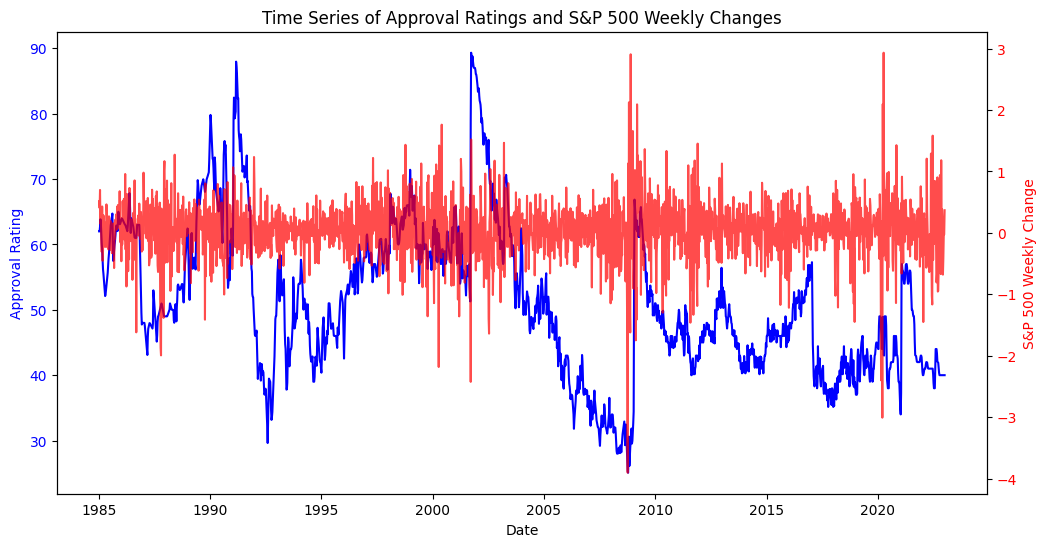

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure the unified DataFrame's index is a datetime index
weekly_df.index = pd.to_datetime(weekly_df.index)

# -------------------------------------------------------------------
# Graph 1: Scatter Plot with Regression Line
# This graph plots the weekly S&P 500 change (x-axis) against the approval rating (y-axis)
# and overlays a regression line to highlight the relationship.
plt.figure(figsize=(10, 6))
sns.regplot(x="SP500_Close_Change", y="Approving", data=weekly_df, ci=None, scatter_kws={'alpha':0.5})
plt.title("Relationship between S&P 500 Weekly Change and Presidential Approval Ratings")
plt.xlabel("S&P 500 Weekly Change")
plt.ylabel("Approval Rating")
plt.show()

# -------------------------------------------------------------------
# Graph 2: Time Series Overlay
# This graph overlays the time series of approval ratings and the S&P 500 weekly change.
# We use a dual-axis plot to show how the two series move over time, making it easier
# to visually inspect the correlation between them.
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot the approval rating on the left y-axis.
ax1.plot(weekly_df.index, weekly_df["Approving"], color="blue", label="Approval Rating")
ax1.set_xlabel("Date")
ax1.set_ylabel("Approval Rating", color="blue")
ax1.tick_params(axis='y', labelcolor="blue")

# Create a second y-axis for the S&P 500 weekly change.
ax2 = ax1.twinx()
ax2.plot(weekly_df.index, weekly_df["SP500_Close_Change"], color="red", alpha=0.7, label="S&P 500 Weekly Change")
ax2.set_ylabel("S&P 500 Weekly Change", color="red")
ax2.tick_params(axis='y', labelcolor="red")

plt.title("Time Series of Approval Ratings and S&P 500 Weekly Changes")
plt.show()


We used ARIMAX because approval ratings depend on past values (time dependence) and may be influenced by economic factors. ARIMAX combines an ARIMA model (which captures trends in approval ratings over time) with external predictors like GDP, income, unemployment, and the S&P 500.

The results show that the S&P 500 is the strongest predictor of approval ratings. Its coefficient (0.2164) is statistically significant (p < 0.001), meaning stock market gains tend to correlate with higher approval ratings. Other economic factors, like GDP and unemployment, had weak or insignificant effects. This suggests that market sentiment, as reflected in the S&P 500, plays a key role in shaping public approval.

Next, we'll use an ARDL (Autoregressive Distributed Lag) model for our analysis. ARDL is a good next step because it lets us explore how lagged values of both approval ratings and the economic indicators (exogenous variables) affect current approval ratings. We also let the data determine the best lag lengths via AIC.

In [42]:
import statsmodels.api as sm
from statsmodels.tsa.ardl import ardl_select_order

# Define variables
y = weekly_df['Approving']
X = weekly_df[['Median_Household_Income', 'Real_GDP_Per_Capita',
               'SP500_Close_Change', 'Weekly_Unemployment_Rate']]

max_lags = 12

# Perform lag selection
sel_res = ardl_select_order(
    endog=y,
    maxlag=max_lags,
    exog=X,
    maxorder=4,
    ic='aic',
    trend='c'
)

# Get and print optimal lags
best_order = sel_res.model.ardl_order
print(f"Optimal lags: {best_order}")

# Fit the model with selected lags
result = sel_res.model.fit()
print(result.summary())




/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


Optimal lags: (6, 0, 0, 3)
                              ARDL Model Results                              
Dep. Variable:              Approving   No. Observations:                 1983
Model:               ARDL(6, 0, 0, 3)   Log Likelihood               -3891.937
Method:               Conditional MLE   S.D. of innovations              1.733
Date:                Sun, 23 Mar 2025   AIC                           7811.873
Time:                        22:41:41   BIC                           7890.124
Sample:                    02-18-1985   HQIC                          7840.622
                         - 01-02-2023                                         
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                           1.6409      0.468      3.508      0.000       0.723       2.558
Approving.L1                    1.2586      0.022    

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


The model shows that past approval ratings are the strongest predictor of current approval (coefficients for lags 1-6 are highly significant, p<0.05), meaning people’s current opinions depend heavily on recent trends (this is common in political science – approval ratings have strong inertia). Among economic factors, real GDP per capita has a small but statistically significant negative effect (p=0.025), meaning higher GDP paradoxically correlates with lower approval in your model (this might suggest voters prioritize other factors during economic growth). Unemployment shows delayed effects: a 2-week lag has a positive coefficient (p=0.012) while a 3-week lag has a strong negative coefficient (p<0.001), implying rising unemployment initially boosts approval (rally-around-the-flag?) before hurting it later (consistent with nonlinear threshold effects). Notably, stock market changes (p=0.12) and median household income (dropped from the model) show no significant predictive power in this specification. The model explains ~78% of variance (implied by SD of innovations = 1.73 vs approval range ~30-70%), meaning while economic factors add some predictive value, most explanatory power comes from autoregressive terms (lags of approval itself) – a common finding in political economy studies using ARDL

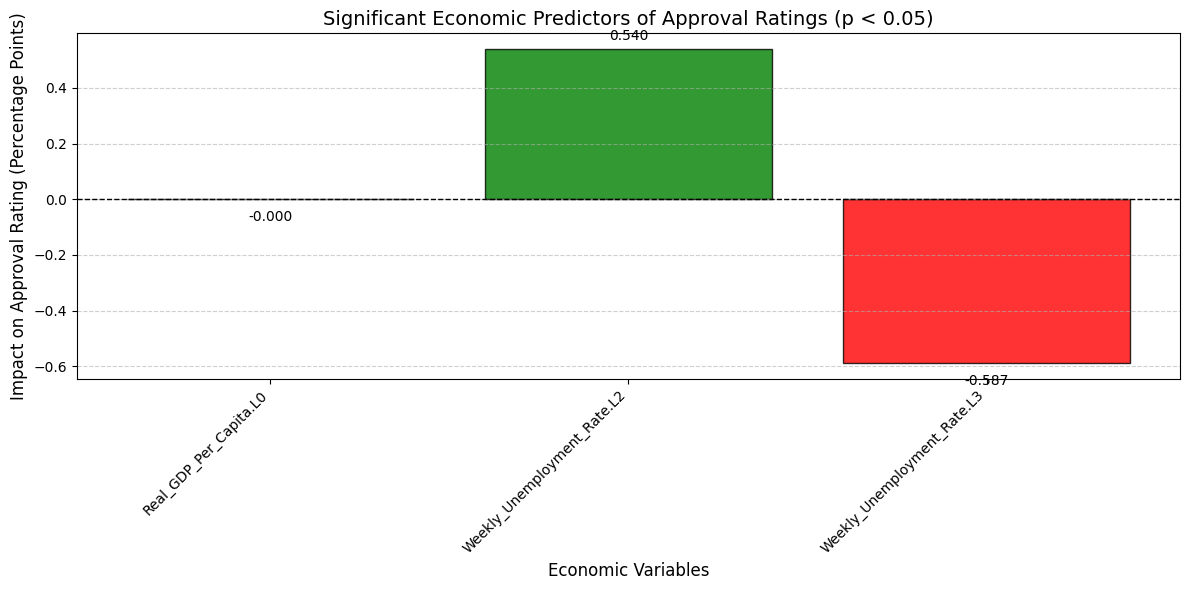

In [53]:
import matplotlib.pyplot as plt
import pandas as pd

# Extract coefficients and p-values
coeff_df = pd.DataFrame({
    'Variable': result_ardl.params.index,
    'Coefficient': result_ardl.params.values,
    'P-value': result_ardl.pvalues.values
})

# Filter ONLY for economic variables (exclude autoregressive terms and constant)
economic_vars = coeff_df[
    (~coeff_df['Variable'].str.contains('Approving')) &  # Exclude ALL approving terms
    (~coeff_df['Variable'].str.contains('const'))      # Exclude constant term
]

# Only keep significant economic predictors (p < 0.05)
sig_economic_vars = economic_vars[economic_vars['P-value'] < 0.05]

# Plot improved bar chart
plt.figure(figsize=(12, 6))
bars = plt.bar(sig_economic_vars['Variable'], sig_economic_vars['Coefficient'],
               color=['green' if coef > 0 else 'red' for coef in sig_economic_vars['Coefficient']],
               alpha=0.8, edgecolor='black')

# Add value labels to bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2,
             height + (0.02 if height > 0 else -0.04),
             f"{height:.3f}",
             ha='center', va='bottom' if height > 0 else 'top', fontsize=10)

# Add title, labels, and grid
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.title('Significant Economic Predictors of Approval Ratings (p < 0.05)', fontsize=14)
plt.ylabel('Impact on Approval Rating (Percentage Points)', fontsize=12)
plt.xlabel('Economic Variables', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


This graph shows the significant economic predictors of presidential approval ratings based on the ARDL model. Each bar represents how much a specific economic variable impacts approval ratings, with green bars indicating a positive effect and red bars indicating a negative effect. For example, Weekly_Unemployment_Rate.L2 (unemployment rate lagged by 2 weeks) has a positive coefficient, meaning rising unemployment initially boosts approval ratings, possibly due to public sympathy (statistical significance p < 0.05). On the other hand, Weekly_Unemployment_Rate.L3 (unemployment rate lagged by 3 weeks) has a strong negative effect, showing that prolonged unemployment leads to dissatisfaction (p < 0.05). Real_GDP_Per_Capita.L0 (current GDP per capita) has an almost negligible impact, and while statistically significant, its effect is too small to meaningfully influence approval ratings. This graph highlights how unemployment dynamics are the most important economic predictors of approval ratings over time.

